In [ ]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import datetime


In [ ]:
df = pd.read_excel('data.xlsx')

In [ ]:
def split_vals(val):
    return pd.Series(val.split(';'))
df[['date', 'conc']] = df['Fecha;PM10'].apply(split_vals)
df = df[['date', 'conc']]

In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

<ipython-input-4-82a6dffc82c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')


In [ ]:
# df['conc'].astype(int)
df['conc'] = pd.to_numeric(df['conc'], errors='coerce').astype('Float64')
df['conc'] = df['conc'].astype(float)

<ipython-input-5-1b5b9eebf0c3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conc'] = pd.to_numeric(df['conc'], errors='coerce').astype('Float64')
<ipython-input-5-1b5b9eebf0c3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conc'] = df['conc'].astype(float)


In [ ]:
df.set_index('date', inplace=True)
df

conc
date            
2010-01-02  21.0
2010-01-05  32.0
2010-01-08   NaN
2010-01-11  27.0
2010-01-14  32.0
...          ...
2015-12-17   NaN
2015-12-20   NaN
2015-12-23   NaN
2015-12-26   NaN
2015-12-29   NaN

[730 rows x 1 columns]

In [ ]:
df.isna().sum()

conc    207
dtype: int64

In [ ]:
df = df[df.index < '2015-01-01']
df

conc
date            
2010-01-02  21.0
2010-01-05  32.0
2010-01-08   NaN
2010-01-11  27.0
2010-01-14  32.0
...          ...
2014-12-19  17.0
2014-12-22  21.0
2014-12-25  24.0
2014-12-28   NaN
2014-12-31   NaN

[609 rows x 1 columns]

In [ ]:
df.isna().sum()

conc    86
dtype: int64

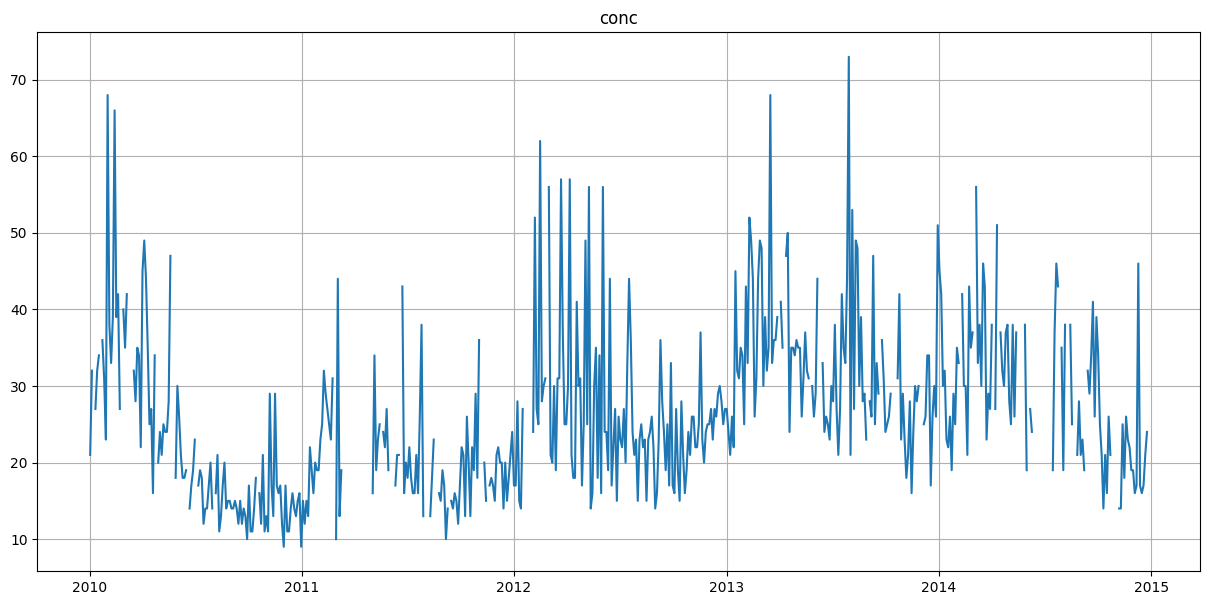

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(df.conc)
plt.title('conc')
plt.grid(True)
plt.show()

In [ ]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day

<ipython-input-11-47dc52cf9283>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df.index.year
<ipython-input-11-47dc52cf9283>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df.index.month
<ipython-input-11-47dc52cf9283>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [ ]:
weight_year=0.5
weight_month=0.3
weight_day=0.2
noise_level=0.1

mean_year = df.groupby('year')['conc'].transform('mean')
mean_month = df.groupby('month')['conc'].transform('mean')
mean_day = df.groupby('day')['conc'].transform('mean')

# Calculate standard deviations
std_year = df.groupby('year')['conc'].transform('std')
std_month = df.groupby('month')['conc'].transform('std')
std_day = df.groupby('day')['conc'].transform('std')

# Combine means with weightage
weighted_mean = (weight_year * mean_year) + (weight_month * mean_month) + (weight_day * mean_day)
weighted_std = (weight_year * std_year) + (weight_month * std_month) + (weight_day * std_day)

np.random.seed(4)
noise = np.random.normal(0, weighted_std * noise_level)

In [ ]:
df['conc_filled'] = df['conc'].combine_first(round(weighted_mean + noise))
df['conc_filled_noise'] = df['conc'].combine_first(round(weighted_mean + noise*weighted_std))

<ipython-input-13-ec172ff78eb9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conc_filled'] = df['conc'].combine_first(round(weighted_mean + noise))
<ipython-input-13-ec172ff78eb9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conc_filled_noise'] = df['conc'].combine_first(round(weighted_mean + noise*weighted_std))


In [ ]:
min(df['conc_filled_noise'])

9.0

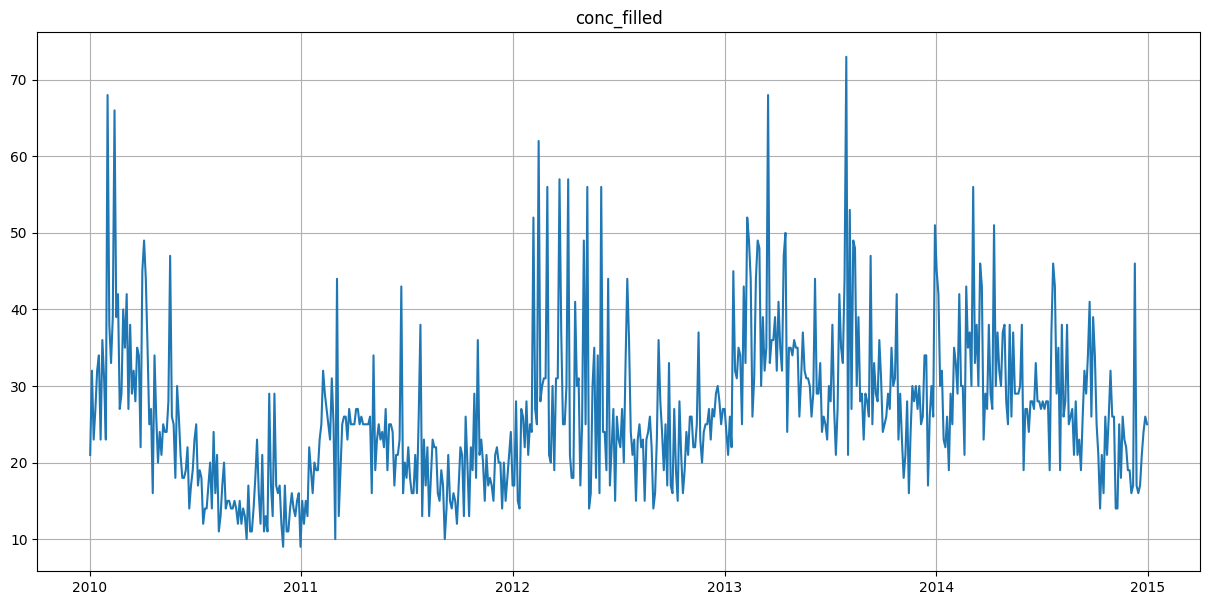

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(df.conc_filled)
plt.title('conc_filled')
plt.grid(True)
plt.show()

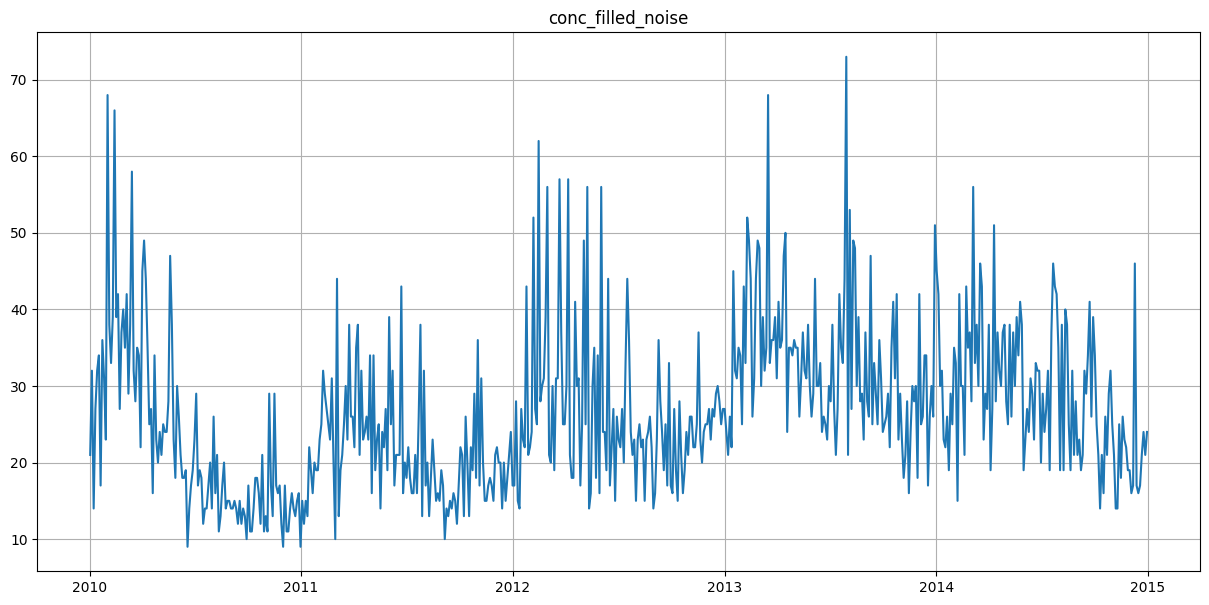

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(df.conc_filled_noise)
plt.title('conc_filled_noise')
plt.grid(True)
plt.show()

In [ ]:
min(df.conc_filled_noise)

9.0

In [ ]:
u = df['conc_filled_noise'].quantile(0.75)
l = df['conc_filled_noise'].quantile(0.25)
r = u - l

lower_bound = l - 1.5*r
upper_bound = u + 1.5 * r

def fix_range(val):
    if val > upper_bound:
        return upper_bound
    elif val < lower_bound:
        return lower_bound
    else:
        return val
df['conc_out'] = df['conc_filled_noise'].apply(fix_range)

<ipython-input-18-45082383f7e8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['conc_out'] = df['conc_filled_noise'].apply(fix_range)


In [ ]:
min(df.conc_out)

9.0

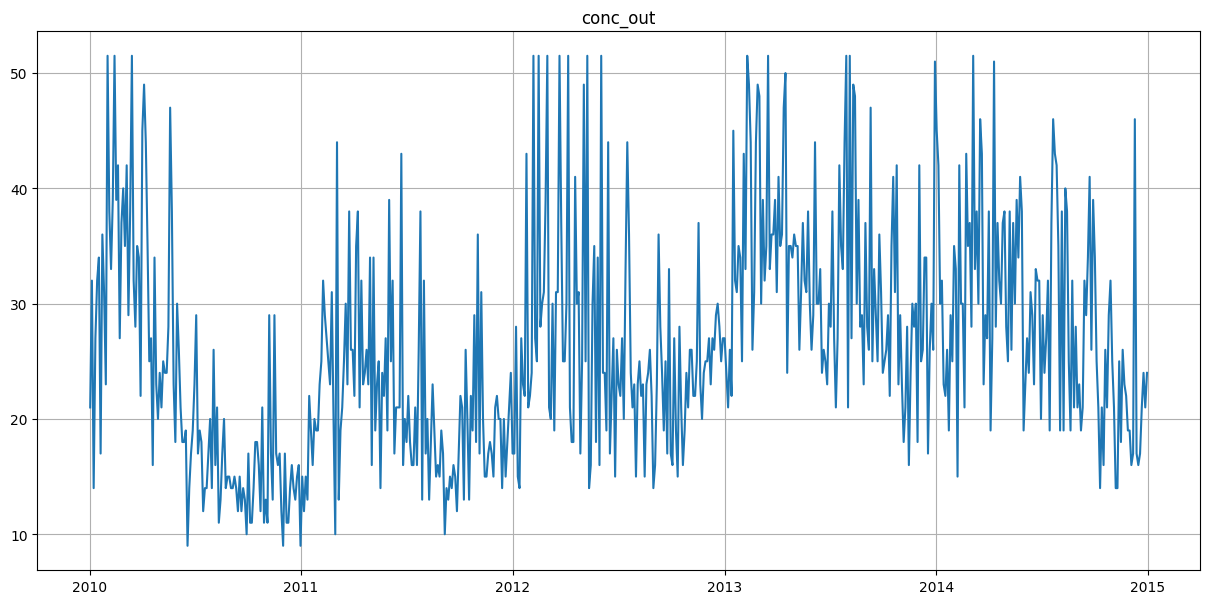

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(df.conc_out)
plt.title('conc_out')
plt.grid(True)
plt.show()

In [ ]:
pm_df = df[['conc_out']]
pm_df.columns = ['conc']
pm_df

conc
date            
2010-01-02  21.0
2010-01-05  32.0
2010-01-08  14.0
2010-01-11  27.0
2010-01-14  32.0
...          ...
2014-12-19  17.0
2014-12-22  21.0
2014-12-25  24.0
2014-12-28  21.0
2014-12-31  24.0

[609 rows x 1 columns]

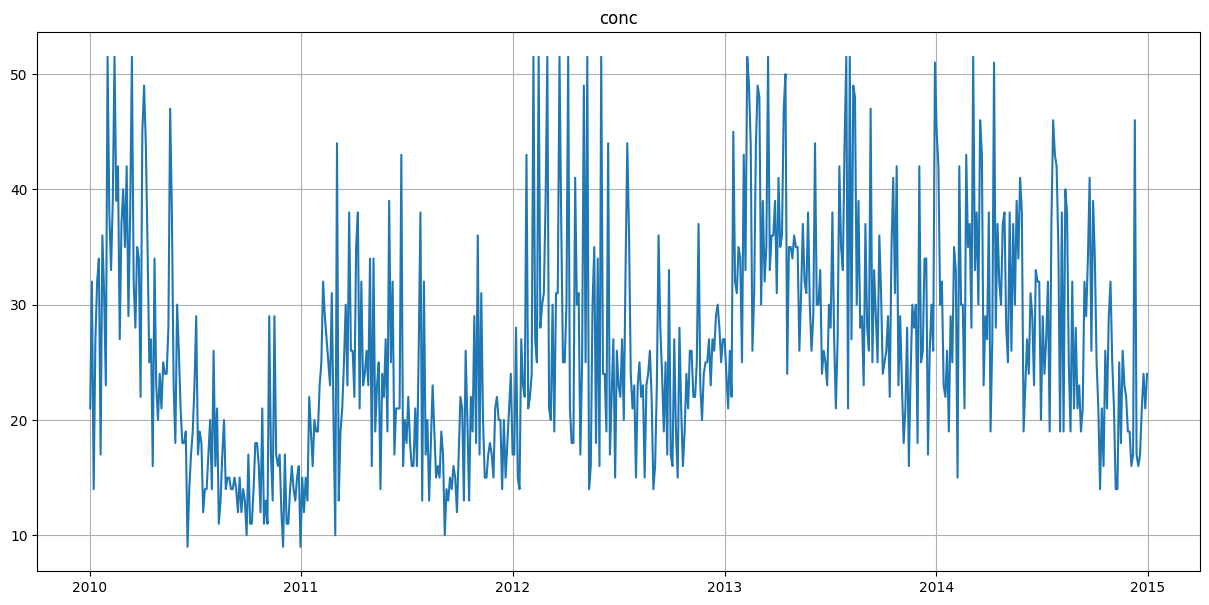

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(pm_df.conc)
plt.title('conc')
plt.grid(True)
plt.show()

In [ ]:
negative_values = pm_df['conc'] < 0
zero_values = pm_df['conc'] == 0
if zero_values.any() or negative_values.any():
  print('yes')

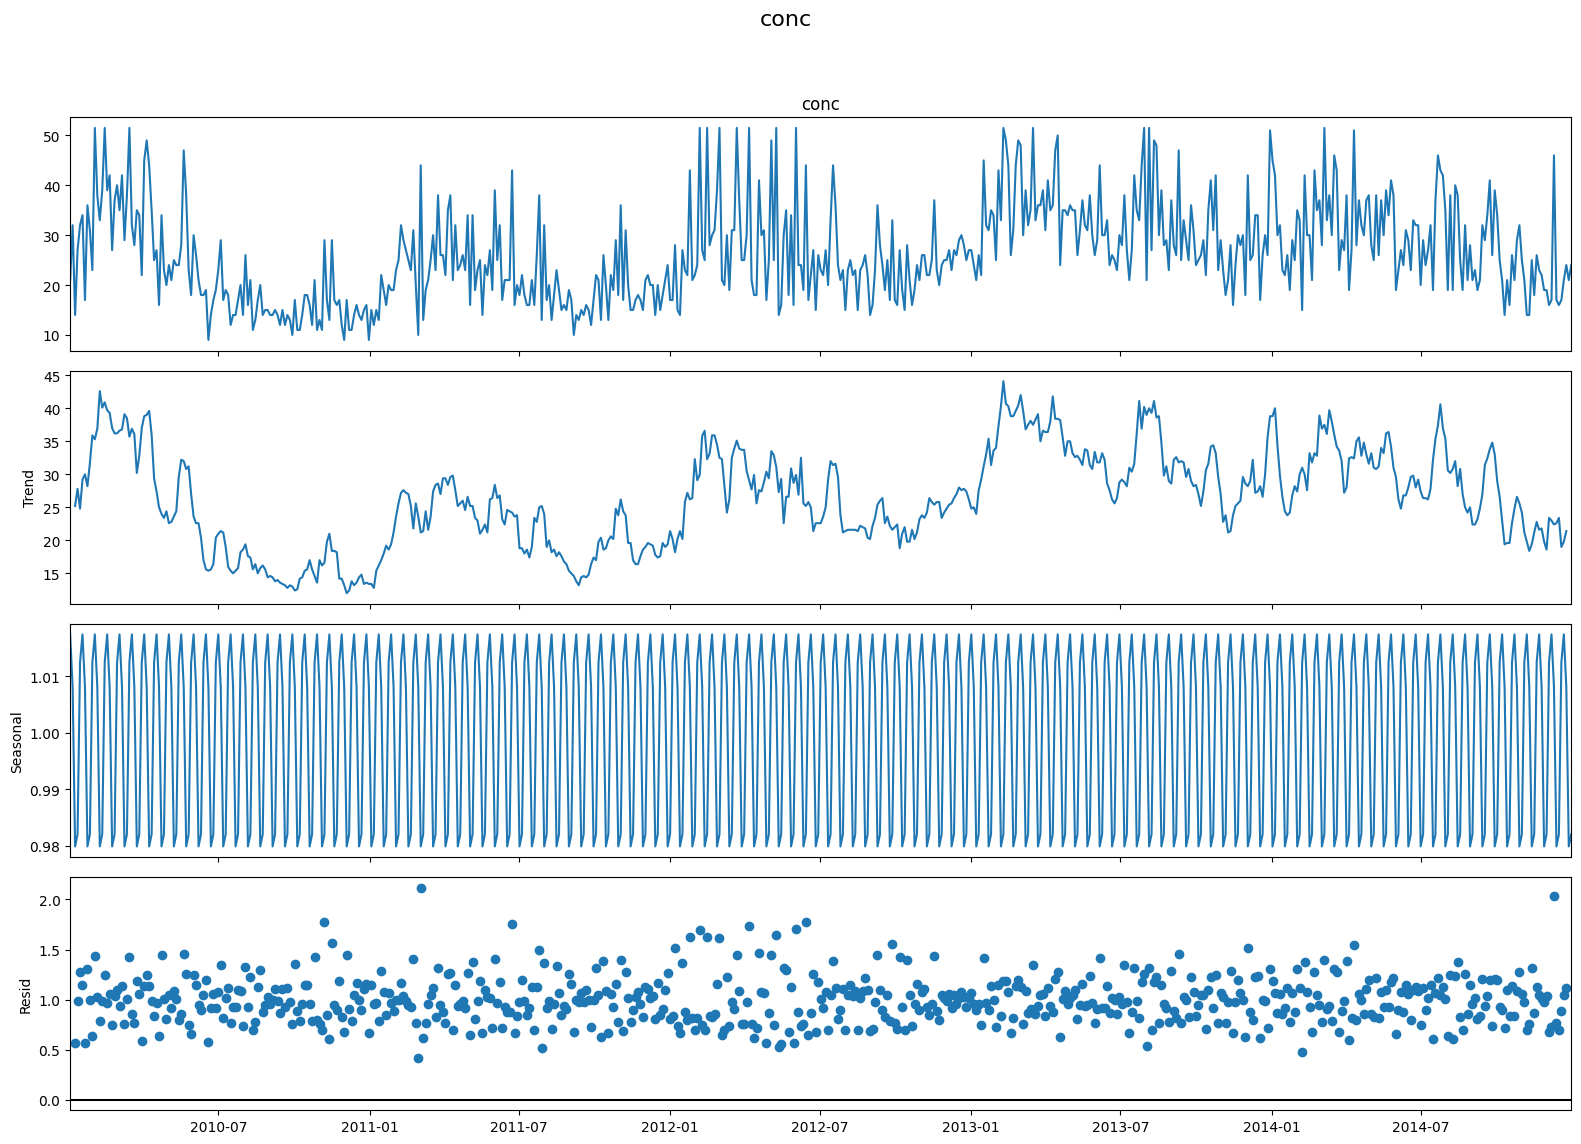

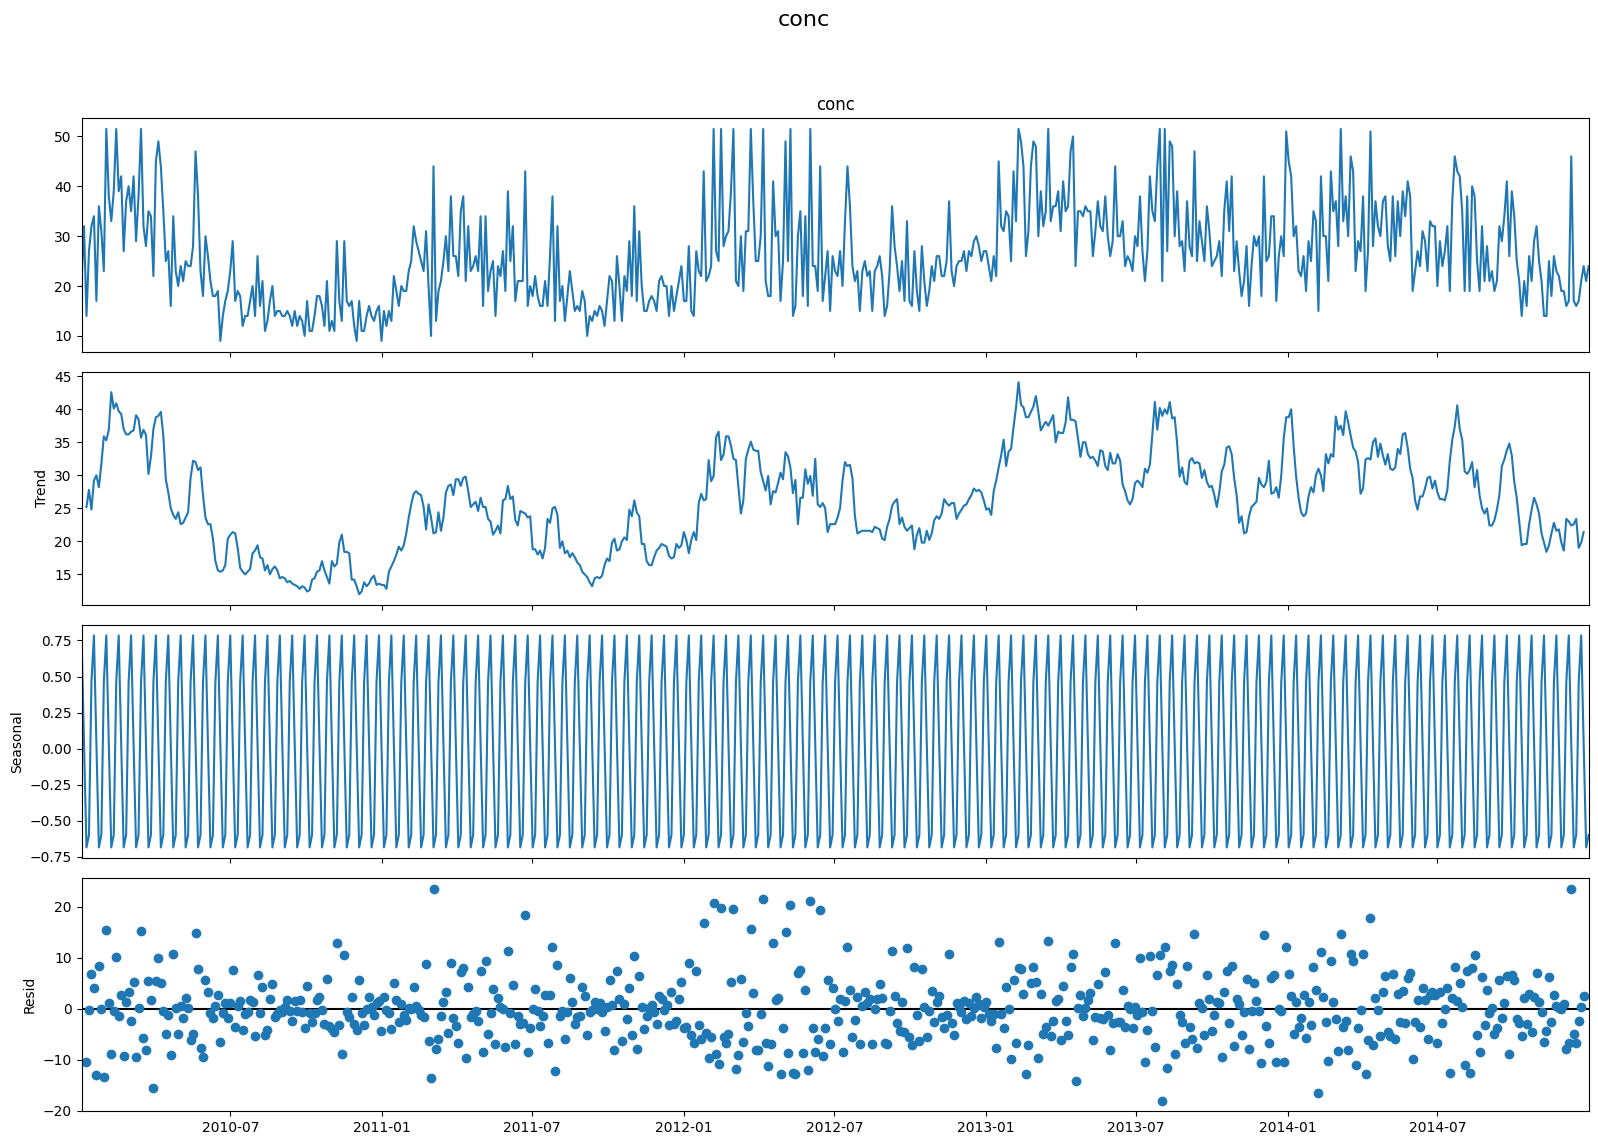

In [ ]:
# Multiplicative Decomposition
multiplicative_decomposition = seasonal_decompose(pm_df['conc'], model='multiplicative', period=5)

# Additive Decomposition
additive_decomposition = seasonal_decompose(pm_df['conc'], model='additive', period=5)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('conc', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('conc', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

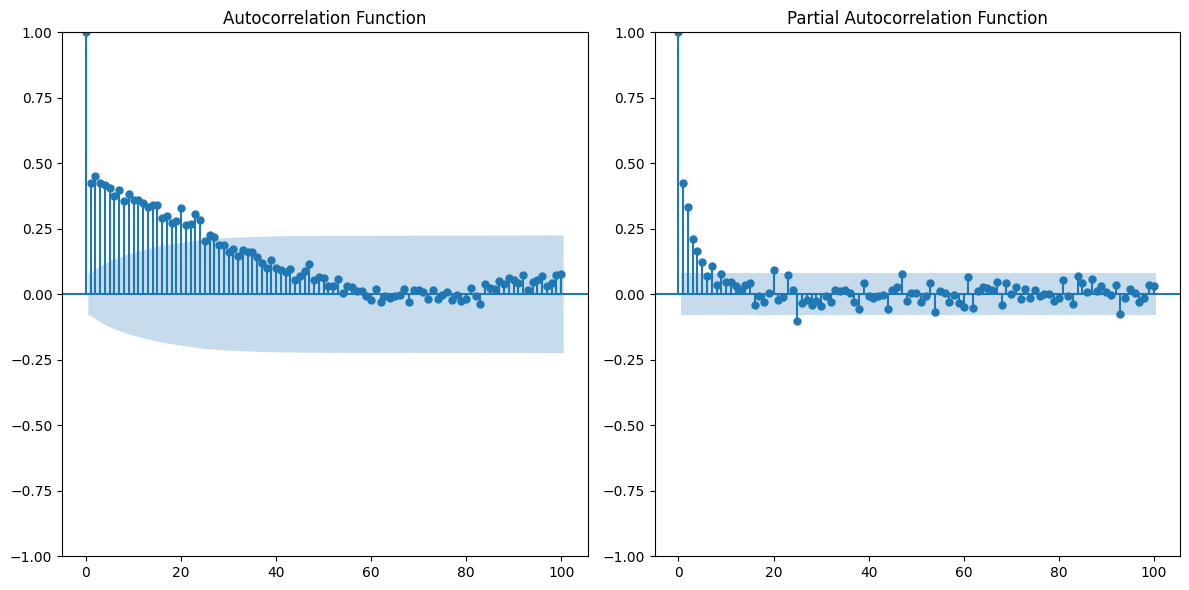

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(pm_df['conc'], ax=plt.gca(), lags=100)
plt.title('Autocorrelation Function')

plt.subplot(122)
plot_pacf(pm_df['conc'], ax=plt.gca(), lags=100)
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
result = adfuller(pm_df['conc'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -3.373312665391721
p-value: 0.011902989299899164
Critical Values: {'1%': -3.4412958288564814, '5%': -2.8663691131481484, '10%': -2.5693418027777777}


In [ ]:
from statsmodels.tsa.stattools import kpss

# Perform the KPSS test
kpss_result = kpss(pm_df['conc'], regression='c', nlags="auto")
print('KPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])
print('Critical Values:', kpss_result[3])

KPSS Statistic: 0.9649071743264278
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


<ipython-input-30-2619b866dcb4>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(pm_df['conc'], regression='c', nlags="auto")


<ipython-input-31-d54bd11a794e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm_df['first_difference'] = pm_df['conc'].diff()


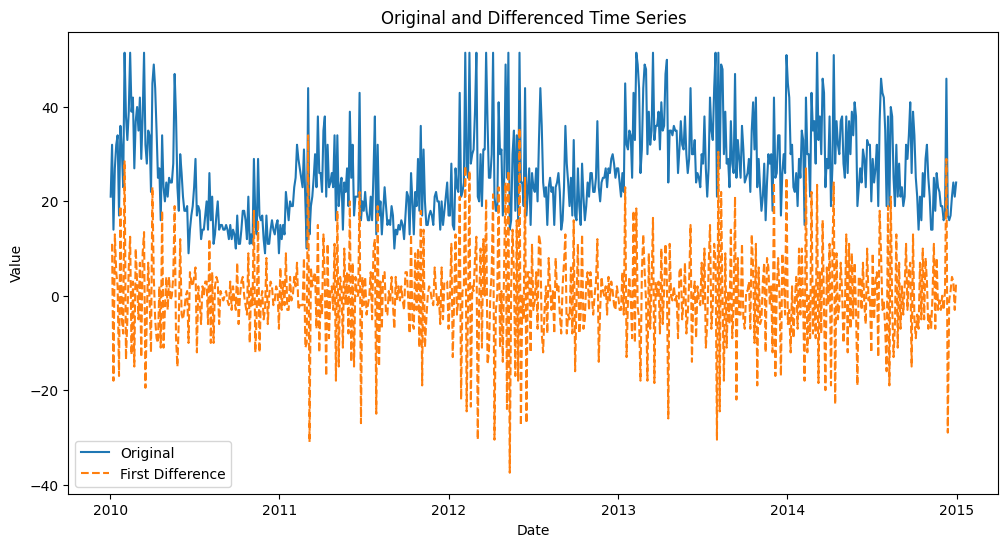

In [ ]:
# Perform differencing
# First-order differencing (subtract each value from the previous one)
pm_df['first_difference'] = pm_df['conc'].diff()

# Second-order differencing
# df_interp['second_difference'] = df_interp['first_difference'].diff()

# Plot the original and differenced time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, pm_df['conc'], label='Original')
plt.plot(df.index, pm_df['first_difference'], label='First Difference', linestyle='--')
# plt.plot(df.index, df_interp['second_difference'], label='Second Difference', linestyle='-.')
plt.title('Original and Differenced Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# Perform the Augmented Dickey-Fuller test
result = adfuller(pm_df['first_difference'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -12.085907980664983
p-value: 2.177917839498054e-22
Critical Values: {'1%': -3.4413325959192393, '5%': -2.86638530474078, '10%': -2.569350430308386}


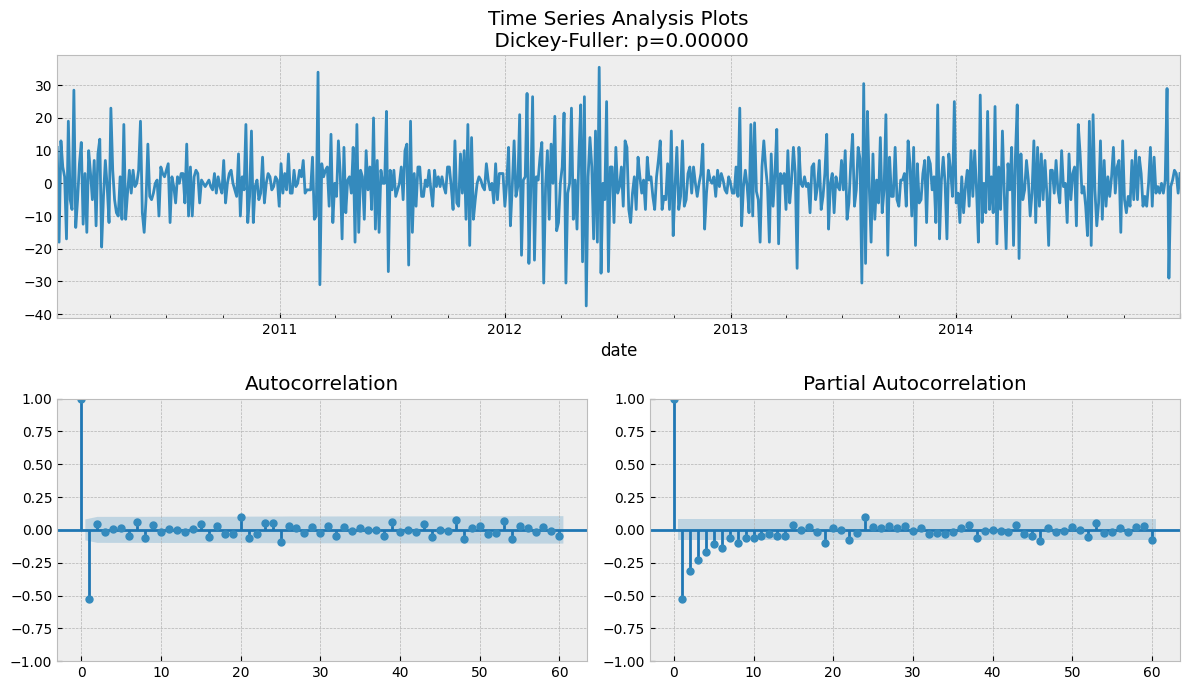

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(pm_df['first_difference'].dropna(), lags=60)

# Model Training

In [ ]:
def mase(y_true, y_pred):
    n = len(y_true)
    d = np.mean(np.abs(np.diff(y_true)))
    errors = np.abs(y_true - y_pred)
    return np.mean(errors) / d

def rmsse(y_true, y_pred):
    n = len(y_true)
    d = np.mean(np.diff(y_true) ** 2)
    mse = np.mean((y_true - y_pred) ** 2)
    return np.sqrt(mse / d)

def tracking_signal(y_true, y_pred):
    forecast_errors = y_true - y_pred
    cumulative_forecast_error = np.sum(forecast_errors)
    mean_absolute_deviation = np.mean(np.abs(forecast_errors))
    return cumulative_forecast_error / mean_absolute_deviation

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9emqizkm/s8lloc8a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9emqizkm/109zm_ln.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26466', 'data', 'file=/tmp/tmp9emqizkm/s8lloc8a.json', 'init=/tmp/tmp9emqizkm/109zm_ln.json', 'output', 'file=/tmp/tmp9emqizkm/prophet_modelzs0h5453/prophet_model-20240523053445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:34:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:34:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


          ds       yhat  yhat_lower  yhat_upper
0 2010-01-02  22.013780   12.057959   32.034924
1 2010-01-05  21.493922   11.481197   30.869308
2 2010-01-08  20.945020   10.925865   30.818626
3 2010-01-11  21.707599   11.886787   31.495147
4 2010-01-14  23.366590   12.878930   33.437162


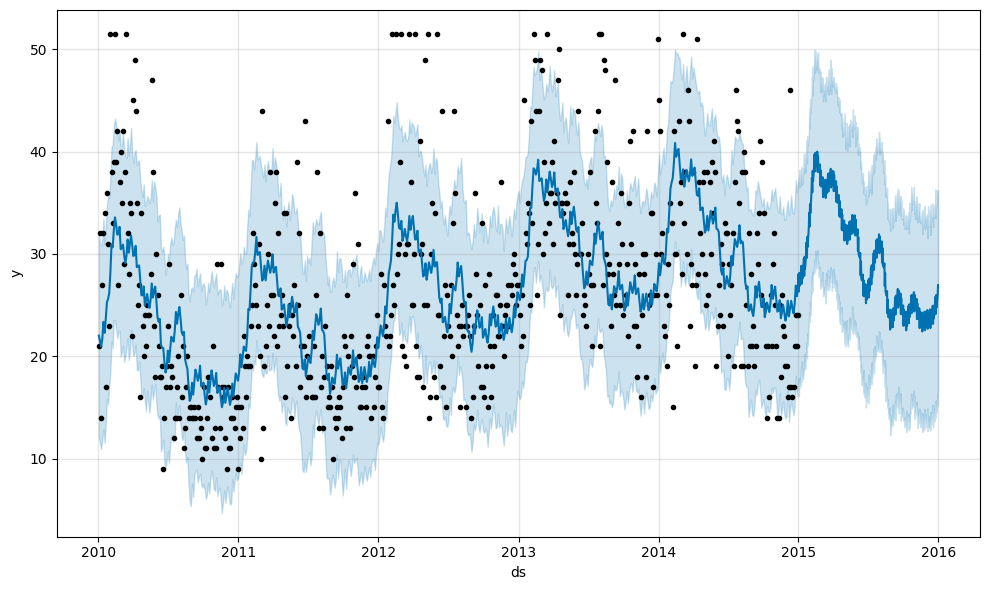

MAE: 6.585
RMSE: 8.089595784474726
MASE: 0.8048092910339636
rmsse: 0.769163081630198
tt: -27.141194911064037


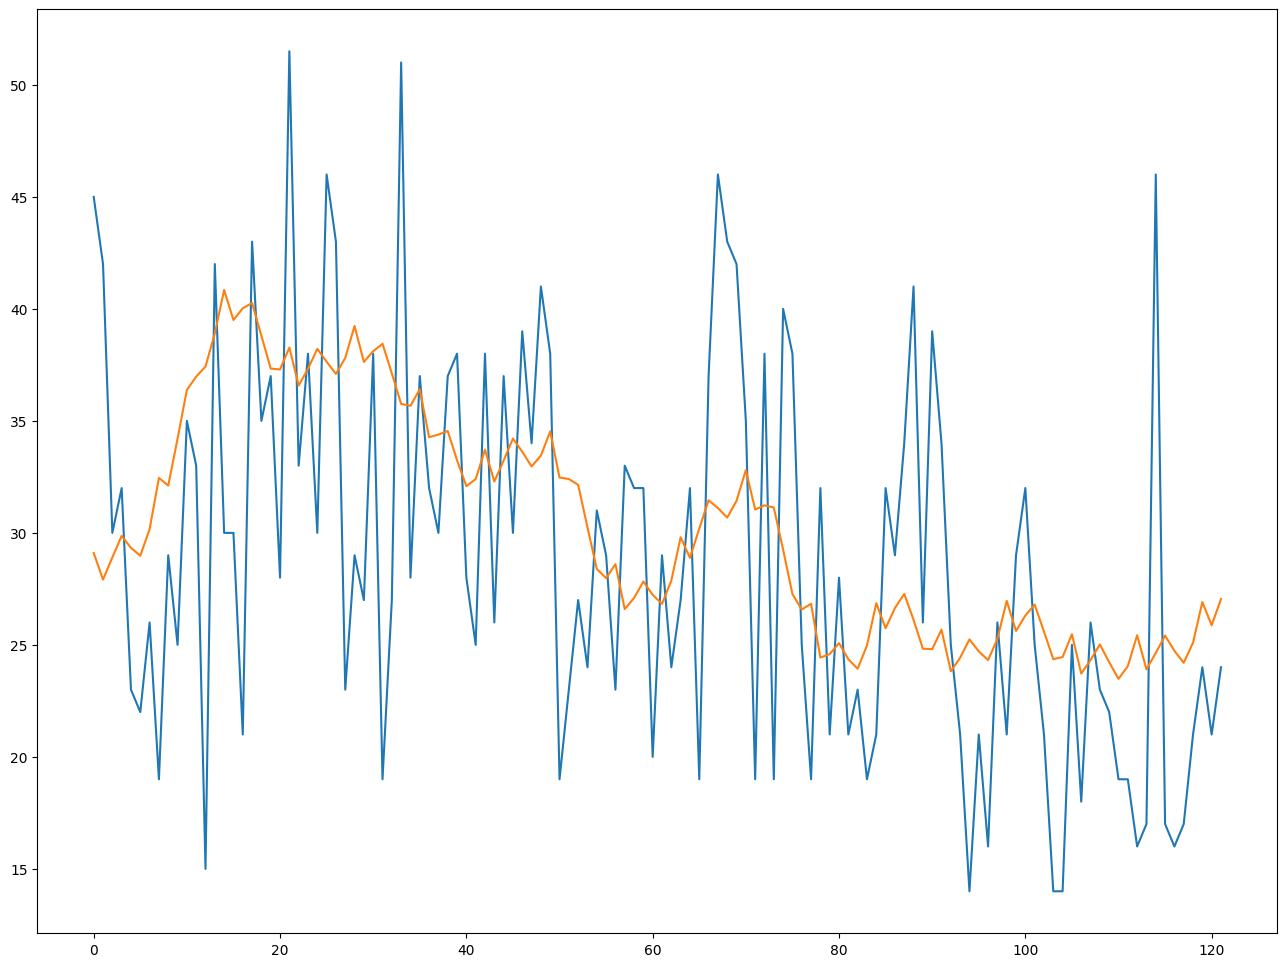

In [ ]:
from prophet import Prophet
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error
# make an in-sample forecast


final_df = pm_df[['conc']]
final_df = final_df.reset_index()
final_df.rename(columns={'date': 'ds', 'conc': 'y'}, inplace=True)


# define the model
model = Prophet()
# fit the model
model.fit(final_df)
# define the period for which we want a prediction
# future = list()
# for i in range(1, 13):
# 	date = '1968-%02d' % i
# 	future.append([date])

# m = Prophet()
# m.fit(df)

for period in [1]:
  future = model.make_future_dataframe(periods=365, freq=f'{period}D')
  future.tail()


  future = pd.DataFrame(future)
  future.columns = ['ds']
  future['ds']= pd.to_datetime(future['ds'])
  # use the model to make a forecast
  forecast = model.predict(future)
  # summarize the forecast
  print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
  # plot forecast
  model.plot(forecast)
  pyplot.show()

  y_true = final_df[final_df['ds'] >= "2014-01-01"]['y'].values
  y_pred = forecast[(forecast['ds'] >= "2014-01-01") & (forecast['ds'] < "2015-01-01")]['yhat'].values


  mae = mean_absolute_error(y_true, y_pred)
  print('MAE: %.3f' % mae)

  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  print('RMSE:', rmse)

  print('MASE:', mase(y_true, y_pred))
  print('rmsse:', rmsse(y_true, y_pred))
  print('tt:', tracking_signal(y_true, y_pred))

  # plot expected vs actual
  pyplot.plot(y_true, label='Actual')
  pyplot.plot(y_pred, label='Predicted')




INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5arpe380/glswbrmk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5arpe380/pzitguq5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18488', 'data', 'file=/tmp/tmp5arpe380/glswbrmk.json', 'init=/tmp/tmp5arpe380/pzitguq5.json', 'output', 'file=/tmp/tmp5arpe380/prophet_modelg5n1upnx/prophet_model-20240519044135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:41:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:41:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds       yhat  yhat_lower  yhat_upper
483 2013-12-21  30.426521   20.738864   40.498314
484 2013-12-24  29.328823   20.136728   38.869694
485 2013-12-27  29.382980   19.474901   39.454455
486 2013-12-30  31.049279   21.945397   41.552962
487 2014-01-29  41.259091   32.512625   51.525702
            ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2010-01-02  23.427643   11.295243   30.733587    23.427643    23.427643   
1   2010-01-05  23.401354    9.775217   30.303649    23.401354    23.401354   
2   2010-01-08  23.375065    9.975186   29.844002    23.375065    23.375065   
3   2010-01-11  23.348777   12.715009   31.544752    23.348777    23.348777   
4   2010-01-14  23.322488   14.204707   33.731518    23.322488    23.322488   
..         ...        ...         ...         ...          ...          ...   
483 2013-12-21  34.343809   20.738864   40.498314    34.343809    34.343809   
484 2013-12-24  34.387412   20.136728   38.869694    34.387412    34

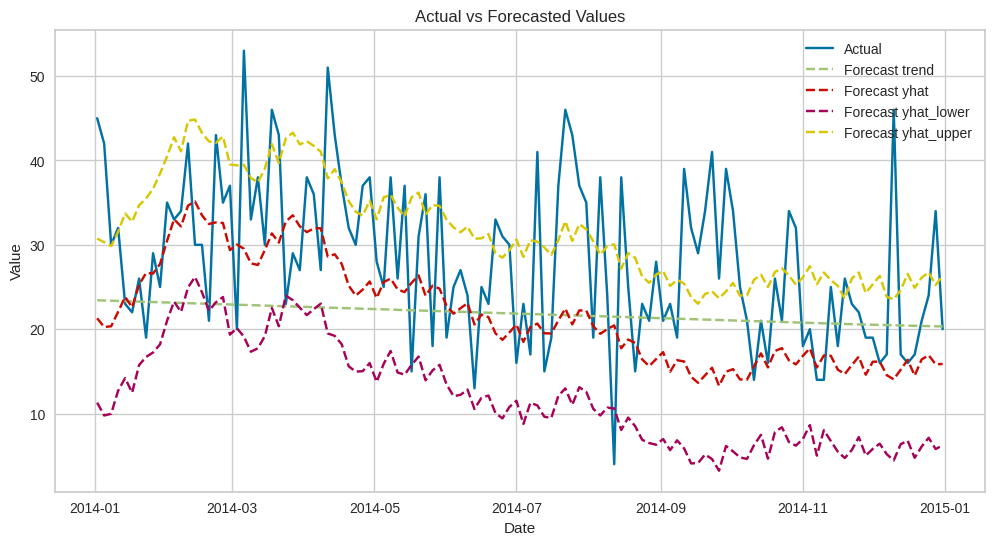

            ds       yhat  yhat_lower  yhat_upper
487 2014-01-29  41.259091   31.767352   50.941404
488 2014-02-28  41.623821   32.051946   51.264347
489 2014-03-30  45.048153   35.914745   54.689655
490 2014-04-29  37.664402   27.971333   46.980931
491 2014-05-29  39.610902   29.667416   49.131426
            ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2010-01-02  23.427643   12.488741   31.011025    23.427643    23.427643   
1   2010-01-05  23.401354   10.286498   29.824223    23.401354    23.401354   
2   2010-01-08  23.375065   10.636631   30.475245    23.375065    23.375065   
3   2010-01-11  23.348777   12.068189   31.990012    23.348777    23.348777   
4   2010-01-14  23.322488   14.616029   33.236035    23.322488    23.322488   
..         ...        ...         ...         ...          ...          ...   
487 2014-01-29  34.910643   31.767352   50.941404    34.895069    34.923509   
488 2014-02-28  35.346669   32.051946   51.264347    35.298406    35

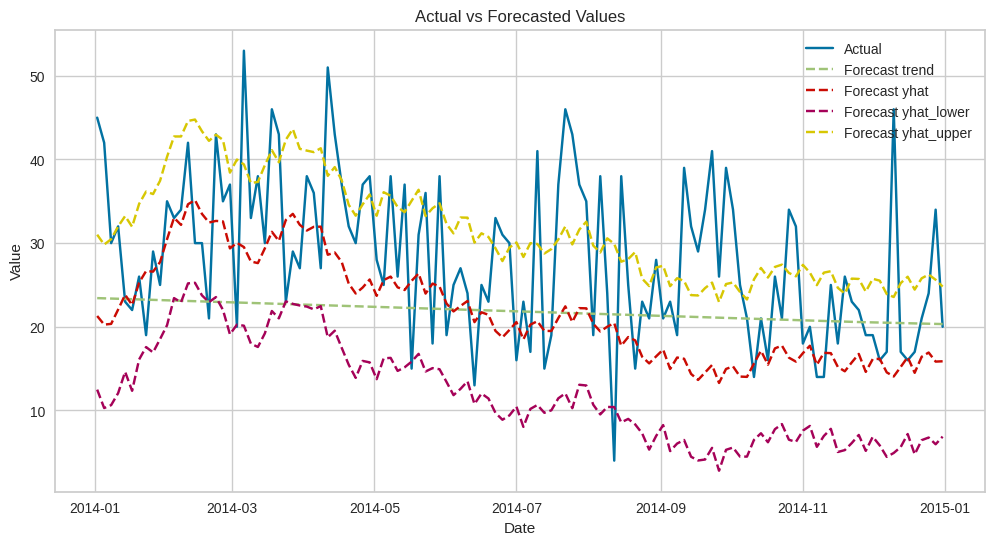

            ds       yhat  yhat_lower  yhat_upper
492 2014-06-28  35.626450   26.213684   44.746905
493 2014-07-28  37.485125   27.652084   47.497314
494 2014-08-27  34.038651   24.737914   43.867611
495 2014-09-26  30.427910   21.343948   40.068896
496 2014-10-26  34.059313   24.507913   44.071779
            ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2010-01-02  23.427643   12.217022   31.266703    23.427643    23.427643   
1   2010-01-05  23.401354   10.464321   30.193075    23.401354    23.401354   
2   2010-01-08  23.375065   10.320792   29.651230    23.375065    23.375065   
3   2010-01-11  23.348777   12.172306   31.482366    23.348777    23.348777   
4   2010-01-14  23.322488   14.377140   32.832437    23.322488    23.322488   
..         ...        ...         ...         ...          ...          ...   
492 2014-06-28  37.090774   26.213684   44.746905    36.780948    37.345886   
493 2014-07-28  37.526800   27.652084   47.497314    37.125357    37

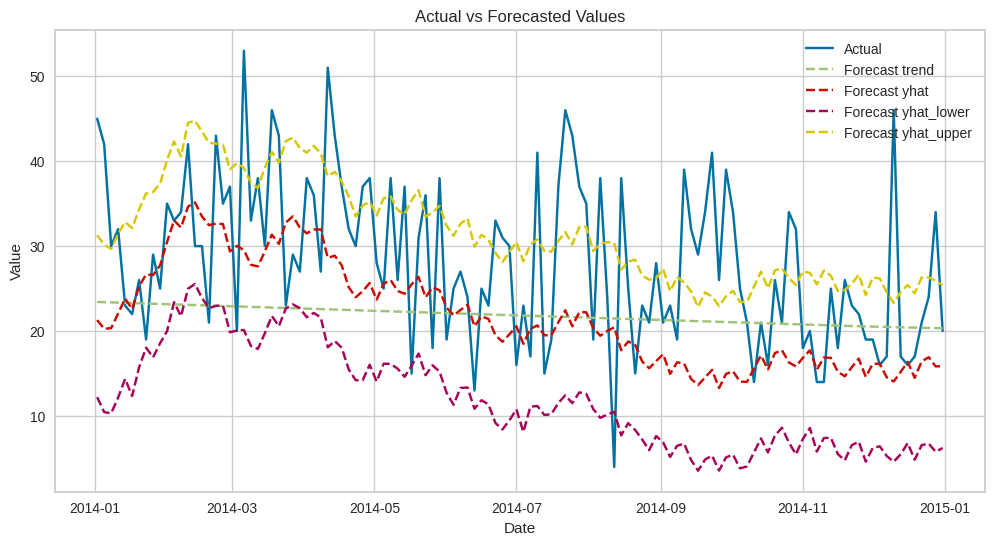

            ds       yhat  yhat_lower  yhat_upper
497 2014-11-25  33.654860   23.752524   43.601071
498 2014-12-25  36.556903   26.789046   45.694848
499 2015-01-24  43.913790   34.589309   53.692196
500 2015-02-23  49.984737   39.842361   59.380598
501 2015-03-25  51.251378   41.929075   60.215986
            ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2010-01-02  23.427643   11.854323   30.760441    23.427643    23.427643   
1   2010-01-05  23.401354   10.538560   29.780740    23.401354    23.401354   
2   2010-01-08  23.375065   10.248823   29.050940    23.375065    23.375065   
3   2010-01-11  23.348777   12.714720   32.213728    23.348777    23.348777   
4   2010-01-14  23.322488   13.697544   34.132658    23.322488    23.322488   
..         ...        ...         ...         ...          ...          ...   
497 2014-11-25  39.270905   23.752524   43.601071    38.592109    40.013381   
498 2014-12-25  39.706931   26.789046   45.694848    38.926222    40

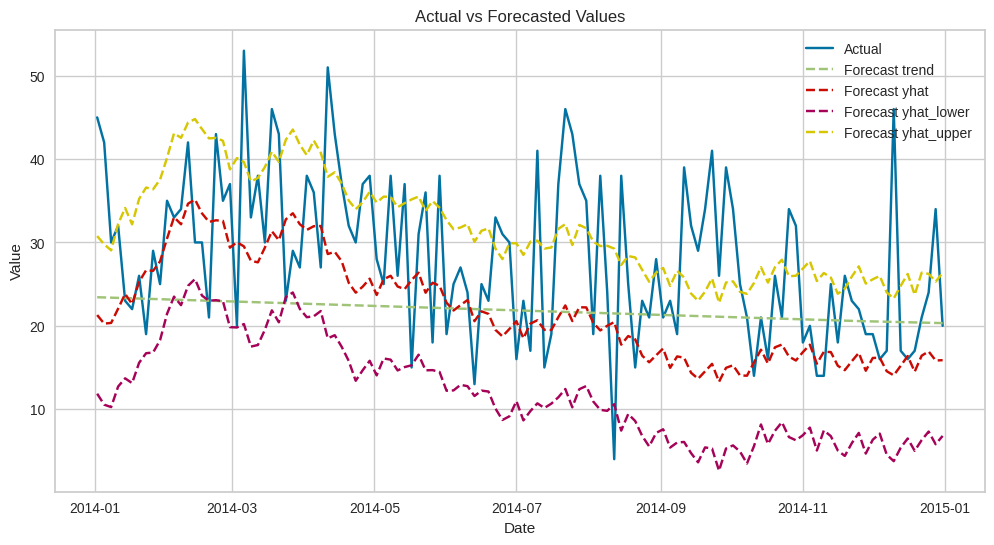

            ds       yhat  yhat_lower  yhat_upper
502 2015-04-24  42.842195   33.229680   52.314827
503 2015-05-24  43.567647   33.709748   53.822865
504 2015-06-23  39.817710   29.830728   50.048810
505 2015-07-23  43.602944   33.934628   53.990602
506 2015-08-22  40.055869   30.260184   50.249127
            ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2010-01-02  23.427643   11.234584   30.357992    23.427643    23.427643   
1   2010-01-05  23.401354   10.367019   30.357660    23.401354    23.401354   
2   2010-01-08  23.375065    9.853766   29.051761    23.375065    23.375065   
3   2010-01-11  23.348777   12.533939   31.738495    23.348777    23.348777   
4   2010-01-14  23.322488   14.677090   34.475655    23.322488    23.322488   
..         ...        ...         ...         ...          ...          ...   
502 2015-04-24  41.451035   33.229680   52.314827    40.217879    42.763424   
503 2015-05-24  41.887061   33.709748   53.822865    40.539689    43

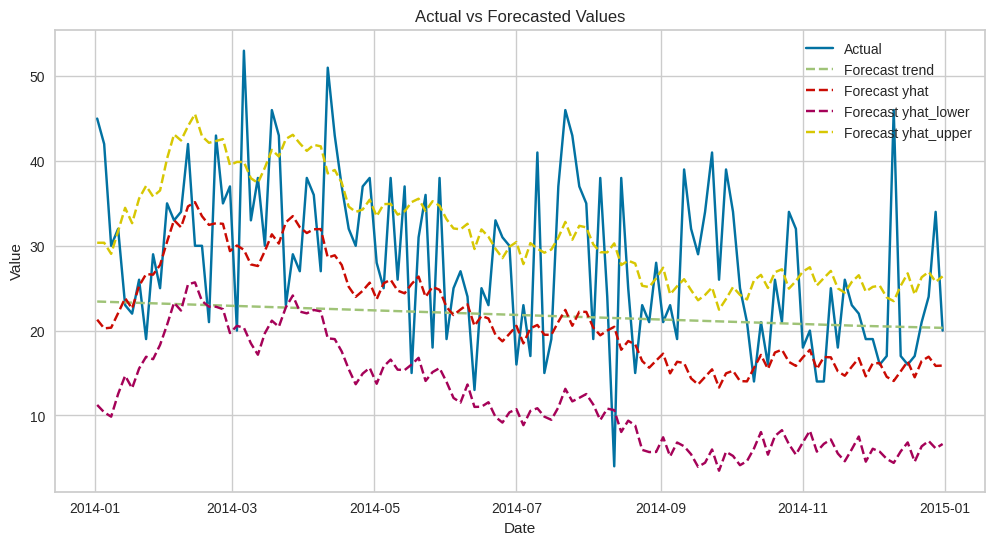

            ds       yhat  yhat_lower  yhat_upper
507 2015-09-21  36.978055   27.470244   46.169119
508 2015-10-21  40.674211   31.181083   50.960319
509 2015-11-20  38.550453   29.108580   48.490603
510 2015-12-20  39.098607   29.542158   48.512773
511 2016-01-19  45.444817   35.668023   55.969382
            ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2010-01-02  23.427643   11.380932   30.783957    23.427643    23.427643   
1   2010-01-05  23.401354   10.888656   30.648770    23.401354    23.401354   
2   2010-01-08  23.375065   10.042347   30.243434    23.375065    23.375065   
3   2010-01-11  23.348777   12.557073   32.129843    23.348777    23.348777   
4   2010-01-14  23.322488   13.882821   33.423698    23.322488    23.322488   
..         ...        ...         ...         ...          ...          ...   
507 2015-09-21  43.631166   27.470244   46.169119    41.766082    45.648198   
508 2015-10-21  44.067192   31.181083   50.960319    42.082013    46

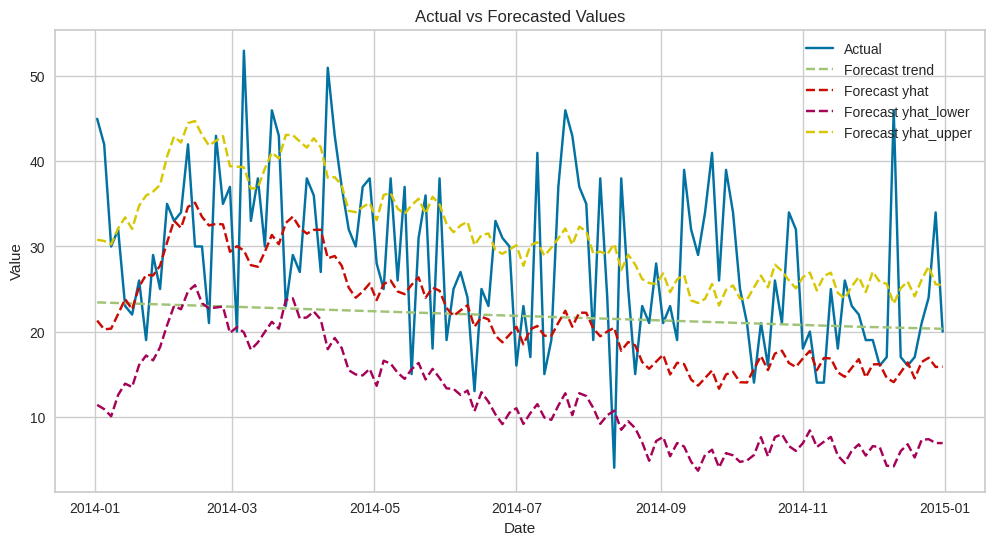

            ds       yhat  yhat_lower  yhat_upper
512 2016-02-18  57.838946   48.005089   68.069790
513 2016-03-19  55.036687   45.238783   65.282839
514 2016-04-18  50.569078   39.655398   61.027647
515 2016-05-18  50.953373   40.197703   60.593971
516 2016-06-17  45.295894   34.298334   55.876615
            ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2010-01-02  23.427643   11.527496   30.703414    23.427643    23.427643   
1   2010-01-05  23.401354   11.023998   30.602860    23.401354    23.401354   
2   2010-01-08  23.375065   11.189894   29.750547    23.375065    23.375065   
3   2010-01-11  23.348777   12.215049   31.598582    23.348777    23.348777   
4   2010-01-14  23.322488   15.063446   33.798562    23.322488    23.322488   
..         ...        ...         ...         ...          ...          ...   
512 2016-02-18  45.811297   48.005089   68.069790    43.006259    48.524545   
513 2016-03-19  46.247323   45.238783   65.282839    43.266382    49

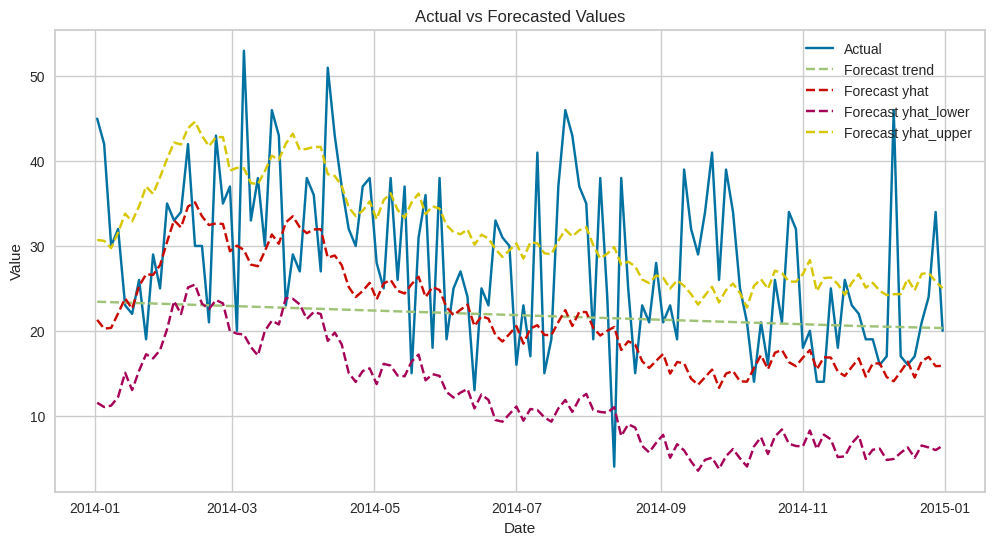

In [ ]:
from prophet import Prophet

final_df = pm_df
final_df = final_df.reset_index()
final_df.rename(columns={'date': 'ds', 'conc': 'y'}, inplace=True)

# Train-Test Split
train_size = int(len(final_df) * 0.8)
train, test = final_df[:train_size], final_df[train_size:]


# Initialize the Prophet model
model = Prophet()
# Fit the model
model.fit(train)


for period in [1, 5, 10, 15, 20, 25, 30]:
    # Create future dataframe
    future = model.make_future_dataframe(periods=period, freq = '30D')

    # Predict
    forecast = model.predict(future)
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

    print(forecast)

    # Plot the actual test values against the forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(test.ds, test.y, label='Actual')
    plt.plot(test.ds, forecast.trend[:122], label='Forecast trend', linestyle='--')
    plt.plot(test.ds, forecast.yhat[:122], label='Forecast yhat', linestyle='--')
    plt.plot(test.ds, forecast.yhat_lower[:122], label='Forecast yhat_lower', linestyle='--')
    plt.plot(test.ds, forecast.yhat_upper[:122], label='Forecast yhat_upper', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Actual vs Forecasted Values')
    plt.legend()
    plt.show()


#LSTM Forecasting Model

In [ ]:
# prompt: build me a lstm time series model on my above data frame pm_df which has data at 3 days interval.

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error


# pm_df = pm_df.reset_index()


# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
pm_df['conc_normalized'] = scaler.fit_transform(pm_df['conc'].values.reshape(-1, 1))

# Split the data into train and test sets
# train_size = int(len(pm_df) * 0.6)
# train_data, test_data = pm_df[:train_size], pm_df[train_size:]

train_size = int(len(pm_df) * 0.6)
train_data, test_data = pm_df[:train_size], pm_df[train_size:]

# Create the training and testing datasets
X_train, y_train = [], []
for i in range(6, len(train_data)):
    X_train.append(train_data['conc_normalized'][i-3:i].values)
    y_train.append(train_data['conc_normalized'][i])
    # X_train.append(train_data[i-3:i, :])
    # y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(6, len(test_data)):
    X_test.append(test_data['conc_normalized'][i-3:i].values)
    y_test.append(test_data['conc_normalized'][i])
    # X_test.append(test_data[i-3:i, :])
    # y_test.append(test_data[i])
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the data for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)
# epochs=10, batch_size=32
# epochs=50, batch_size=1, validation_split=0.2
# epochs=50, batch_size=16, validation_split=0.2

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions
# predictions = scaler.inverse_transform(predictions)
# y_test = scaler.inverse_transform(y_test)
predictions = predictions.reshape(-1)
y_test = y_test.reshape(-1)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE:', rmse)

mae = mean_absolute_error(y_test, predictions)
print('MAE: %.3f' % mae)

print('MASE:', mase(y_test, predictions))
print('rmsse:', rmsse(y_test, predictions))
print('tt:', tracking_signal(y_test, predictions))


Epoch 1/50
18/18 [==============================] - 13s 57ms/step - loss: 0.1024 - val_loss: 0.0345
Epoch 2/50
18/18 [==============================] - 0s 6ms/step - loss: 0.0443 - val_loss: 0.0285
Epoch 3/50
18/18 [==============================] - 0s 8ms/step - loss: 0.0434 - val_loss: 0.0290
Epoch 4/50
18/18 [==============================] - 0s 7ms/step - loss: 0.0399 - val_loss: 0.0302
Epoch 5/50
18/18 [==============================] - 0s 7ms/step - loss: 0.0389 - val_loss: 0.0299
Epoch 6/50
18/18 [==============================] - 0s 7ms/step - loss: 0.0411 - val_loss: 0.0301
Epoch 7/50
18/18 [==============================] - 0s 7ms/step - loss: 0.0384 - val_loss: 0.0305
Epoch 8/50
18/18 [==============================] - 0s 7ms/step - loss: 0.0400 - val_loss: 0.0312
Epoch 9/50
18/18 [==============================] - 0s 7ms/step - loss: 0.0387 - val_loss: 0.0309
Epoch 10/50
18/18 [==============================] - 0s 7ms/step - loss: 0.0400 - val_loss: 0.0314
Epoch 11/50
18/18

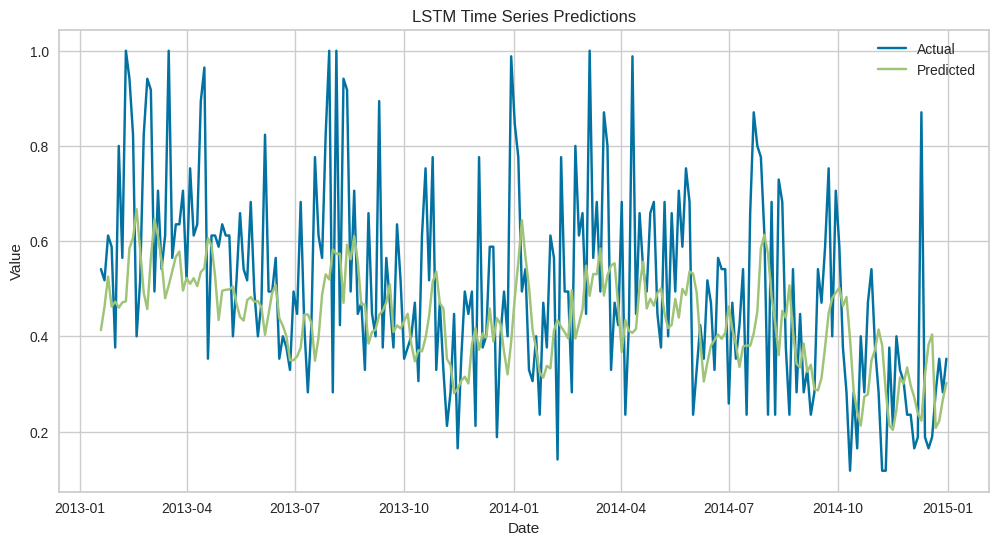

In [ ]:
# Plot the predictions
# epochs=50, batch_size=16, validation_split=0.2
plt.figure(figsize=(12, 6))
plt.plot(test_data[6:].index, y_test, label='Actual')
plt.plot(test_data[6:].index, predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('LSTM Time Series Predictions')
plt.legend()
plt.show()

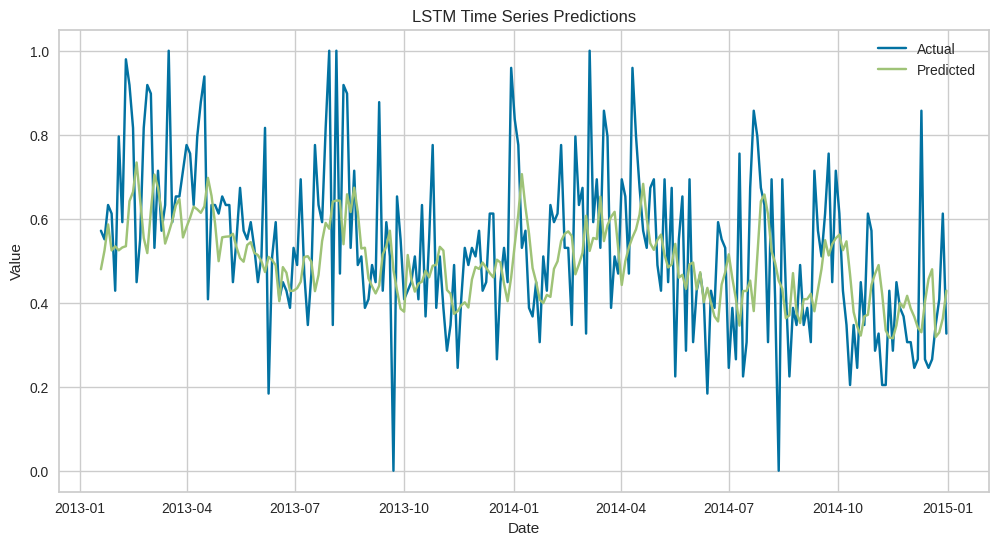

In [ ]:
# Plot the predictions
# epochs=50, batch_size=16, validation_split=0.2
plt.figure(figsize=(12, 6))
plt.plot(test_data[6:].index, y_test, label='Actual')
plt.plot(test_data[6:].index, predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('LSTM Time Series Predictions')
plt.legend()
plt.show()

# Auto ML Prediction Model

In [ ]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 

In [ ]:
from pycaret.time_series import *

data= pm_df[['conc']]

# Initialize the PyCaret setup
s = setup(data,
                 fh=12,  # Forecast horizon
                 session_id=123,
                 fold=5)  # Number of cross-validation folds

# Compare all models and select the best one
best_model = compare_models()

# Tune the best model
tuned_model = tune_model(best_model)

# Finalize the tuned model
final_model = finalize_model(tuned_model)

# Make predictions
future_predictions = predict_model(final_model, fh=60)

# Plot the results
plot_model(final_model, plot='forecast', data_kwargs={'fh': 30})

# Print the future predictions
print(future_predictions)


Processing:   0%|          | 0/109 [00:00<?, ?it/s]

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


             y_pred
2015-01-03  26.3325
2015-01-06  26.3325
2015-01-09  26.3325
2015-01-12  26.3325
2015-01-15  26.3325
2015-01-18  26.3325
2015-01-21  26.3325
2015-01-24  26.3325
2015-01-27  26.3325
2015-01-30  26.3325
2015-02-02  26.3325
2015-02-05  26.3325
2015-02-08  26.3325
2015-02-11  26.3325
2015-02-14  26.3325
2015-02-17  26.3325
2015-02-20  26.3325
2015-02-23  26.3325
2015-02-26  26.3325
2015-03-01  26.3325
2015-03-04  26.3325
2015-03-07  26.3325
2015-03-10  26.3325
2015-03-13  26.3325
2015-03-16  26.3325
2015-03-19  26.3325
2015-03-22  26.3325
2015-03-25  26.3325
2015-03-28  26.3325
2015-03-31  26.3325
2015-04-03  26.3325
2015-04-06  26.3325
2015-04-09  26.3325
2015-04-12  26.3325
2015-04-15  26.3325
2015-04-18  26.3325
2015-04-21  26.3325
2015-04-24  26.3325
2015-04-27  26.3325
2015-04-30  26.3325
2015-05-03  26.3325
2015-05-06  26.3325
2015-05-09  26.3325
2015-05-12  26.3325
2015-05-15  26.3325
2015-05-18  26.3325
2015-05-21  26.3325
2015-05-24  26.3325
2015-05-27  26.3325


In [ ]:
from pycaret.time_series import *

data= pm_df[['conc']]

# Initialize the PyCaret setup
s = setup(data,
                 fh=30,  # Forecast horizon
                 session_id=123,
                 fold=3)  # Number of cross-validation folds


In [ ]:
check_stats()

Test   Test Name         Data             Property  \
0        Summary  Statistics  Transformed               Length   
1        Summary  Statistics  Transformed     # Missing Values   
2        Summary  Statistics  Transformed                 Mean   
3        Summary  Statistics  Transformed               Median   
4        Summary  Statistics  Transformed   Standard Deviation   
5        Summary  Statistics  Transformed             Variance   
6        Summary  Statistics  Transformed             Kurtosis   
7        Summary  Statistics  Transformed             Skewness   
8        Summary  Statistics  Transformed    # Distinct Values   
9    White Noise   Ljung-Box  Transformed       Test Statictic   
10   White Noise   Ljung-Box  Transformed       Test Statictic   
11   White Noise   Ljung-Box  Transformed              p-value   
12   White Noise   Ljung-Box  Transformed              p-value   
13   White Noise   Ljung-Box  Transformed          White Noise   
14   White Noise   Ljung-Box  Transformed          White Noise   
15  Stationarity         ADF  Transformed         Stationarity   
16  Stationarity         ADF  Transformed              p-value   
17  Stationarity         ADF  Transformed       Test Statistic   
18  Stationarity         ADF  Transformed    Critical Value 1%   
19  Stationarity         ADF  Transformed    Critical Value 5%   
20  Stationarity         ADF  Transformed   Critical Value 10%   
21  Stationarity        KPSS  Transformed   Trend Stationarity   
22  Stationarity        KPSS  Transformed              p-value   
23  Stationarity        KPSS  Transformed       Test Statistic   
24  Stationarity        KPSS  Transformed   Critical Value 10%   
25  Stationarity        KPSS  Transformed    Critical Value 5%   
26  Stationarity        KPSS  Transformed  Critical Value 2.5%   
27  Stationarity        KPSS  Transformed    Critical Value 1%   
28     Normality     Shapiro  Transformed            Normality   
29     Normality     Shapiro  Transformed              p-value   

                     Setting        Value  
0                                   609.0  
1                                     0.0  
2                               26.332512  
3                                    25.0  
4                                 9.79749  
5                               95.990816  
6                               -0.085249  
7                                0.675377  
8                                    44.0  
9   {'alpha': 0.05, 'K': 24}  1835.814123  
10  {'alpha': 0.05, 'K': 48}  2156.935285  
11  {'alpha': 0.05, 'K': 24}          0.0  
12  {'alpha': 0.05, 'K': 48}          0.0  
13  {'alpha': 0.05, 'K': 24}          0.0  
14  {'alpha': 0.05, 'K': 48}          0.0  
15           {'alpha': 0.05}         True  
16           {'alpha': 0.05}     0.011903  
17           {'alpha': 0.05}    -3.373313  
18           {'alpha': 0.05}    -3.441296  
19           {'alpha': 0.05}    -2.866369  
20           {'alpha': 0.05}    -2.569342  
21           {'alpha': 0.05}        False  
22           {'alpha': 0.05}     0.015641  
23           {'alpha': 0.05}     0.200958  
24           {'alpha': 0.05}        0.119  
25           {'alpha': 0.05}        0.146  
26           {'alpha': 0.05}        0.176  
27           {'alpha': 0.05}        0.216  
28           {'alpha': 0.05}        False  
29           {'alpha': 0.05}          0.0

In [ ]:
plot_model(plot='diagnostics')

In [ ]:
# Compare all models and select the best one
best_model = compare_models()

Processing:   0%|          | 0/109 [00:00<?, ?it/s]



#Auto Arima Prediction Model


In [ ]:
data= pm_df[['conc']]

# Initialize the PyCaret setup
s = setup(data,
                 fh=30,  # Forecast horizon
                 session_id=123,
                 fold=5)  # Number of cross-validation folds
arima = create_model('auto_arima')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
arima_tuned = tune_model(arima)
final_arima = finalize_model(arima_tuned)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.9s finished


In [ ]:
# Make predictions
future_predictions = predict_model(final_arima, fh=30)

# Plot the results
plot_model(final_arima, plot='forecast', data_kwargs={'fh': 30})

  # TPOT prediction model

In [ ]:
!pip install tpot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11938 sha256=c81ade923525423362a11f087d6e764b779290d4c2dfc37d156b82ff85e96d6e
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tpot import TPOTRegressor


def create_lag_features(df, n_lags=3):
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df['conc'].shift(lag)
    return df

# Create lag features
n_lags = 3
df = create_lag_features(data, n_lags)

# Drop rows with NaN values (due to lagging)
df.dropna(inplace=True)

In [ ]:
df

conc  lag_1  lag_2  lag_3
date                                 
2010-01-11  27.0   14.0   32.0   21.0
2010-01-14  32.0   27.0   14.0   32.0
2010-01-17  34.0   32.0   27.0   14.0
2010-01-20  17.0   34.0   32.0   27.0
2010-01-23  36.0   17.0   34.0   32.0
...          ...    ...    ...    ...
2014-12-19  17.0   16.0   17.0   46.0
2014-12-22  21.0   17.0   16.0   17.0
2014-12-25  24.0   21.0   17.0   16.0
2014-12-28  21.0   24.0   21.0   17.0
2014-12-31  24.0   21.0   24.0   21.0

[606 rows x 4 columns]

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into features (X) and target (y)
X = df.drop(columns=['conc'])
y = df['conc']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [ ]:
# Initialize TPOTRegressor
tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2, random_state=42)

# Fit TPOT to the training data
tpot.fit(X_train, y_train)


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -66.0059684198948

Generation 2 - Current best internal CV score: -66.0059684198948

Generation 3 - Current best internal CV score: -66.0059684198948

Generation 4 - Current best internal CV score: -66.0059684198948

Generation 5 - Current best internal CV score: -66.0059684198948

Best pipeline: RandomForestRegressor(ElasticNetCV(input_matrix, l1_ratio=0.75, tol=0.01), bootstrap=True, max_features=0.4, min_samples_leaf=16, min_samples_split=14, n_estimators=100)


TPOTRegressor(generations=5, population_size=20, random_state=42, verbosity=2)

In [ ]:
# Evaluate the model on the test set
score = tpot.score(X_test, y_test)
print(f'Test R^2 score: {score}')

# Make predictions
y_pred = tpot.predict(X_test)

Test R^2 score: -67.72974532033774


In [ ]:
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mae)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

print('MASE:', mase(y_test, y_pred))
print('rmsse:', rmsse(y_test, y_pred))
print('tt:', tracking_signal(y_test, y_pred))

MAE: 6.575
RMSE: 8.229808340437689
MASE: 0.8036010336173671
rmsse: 0.7824945662310346
tt: 8.946156120100511


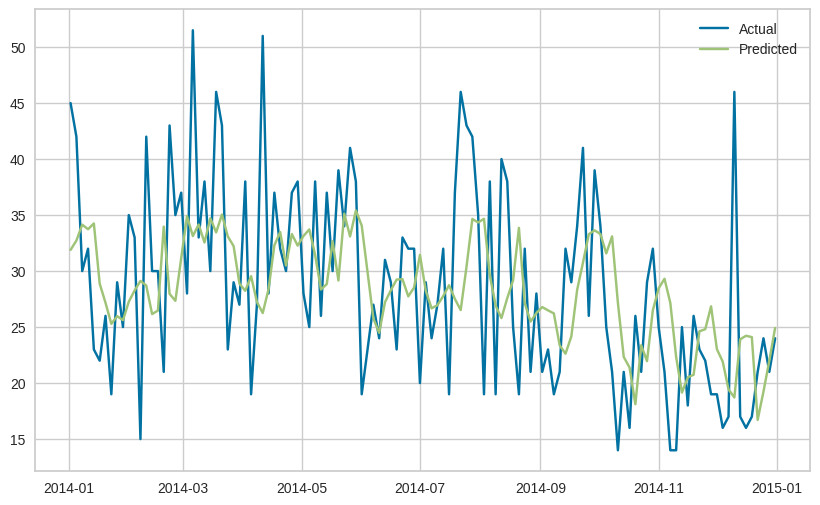

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

In [ ]:
tpot = TPOTRegressor(generations=5, population_size=50, cv=5, random_state=42, scoring='neg_mean_absolute_error', verbosity=2, n_jobs=-1)
# Fit TPOT to the training data
tpot.fit(X_train, y_train)

# Evaluate the model on the test set
score = tpot.score(X_test, y_test)
print(f'Test R^2 score: {score}')

# Make predictions
y_pred = tpot.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mae)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

print('MASE:', mase(y_test, y_pred))
print('rmsse:', rmsse(y_test, y_pred))
print('tt:', tracking_signal(y_test, y_pred))

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -6.174784560393438

Generation 2 - Current best internal CV score: -6.174784560393438

Generation 3 - Current best internal CV score: -6.174784560393438

Generation 4 - Current best internal CV score: -6.174784560393438

Generation 5 - Current best internal CV score: -6.157279867164215

Best pipeline: LinearSVR(input_matrix, C=0.01, dual=True, epsilon=0.001, loss=squared_epsilon_insensitive, tol=0.0001)
Test R^2 score: -6.717175848847062
MAE: 6.717
RMSE: 8.45813191070202
MASE: 0.8209881593035299
rmsse: 0.8042036930640913
tt: 8.303673954503079
